# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Generating-Synthetic-Data" data-toc-modified-id="Generating-Synthetic-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generating Synthetic Data</a></div><div class="lev1 toc-item"><a href="#Estimating-confidence-intervals-using-the-non-parametric-bootstrap" data-toc-modified-id="Estimating-confidence-intervals-using-the-non-parametric-bootstrap-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Estimating confidence intervals using the non-parametric bootstrap</a></div><div class="lev1 toc-item"><a href="#The-Mann-Whitney-U-test-for-equality-of-distributions" data-toc-modified-id="The-Mann-Whitney-U-test-for-equality-of-distributions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The Mann-Whitney U test for equality of distributions</a></div><div class="lev1 toc-item"><a href="#Statistical-testing-using-the-non-parametric-bootstrap" data-toc-modified-id="Statistical-testing-using-the-non-parametric-bootstrap-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Statistical testing using the non-parametric bootstrap</a></div><div class="lev1 toc-item"><a href="#Repeating-the-analysis-for-a-different-sample-is-straightforward" data-toc-modified-id="Repeating-the-analysis-for-a-different-sample-is-straightforward-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Repeating the analysis for a different sample is straightforward</a></div>

Welcome to our Primer on the Non-parametric Bootstrap.

As usual, before we begin, we upload the useful libraries. 

In [1]:
import pandas as pd
import numpy as np
import scipy as scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# set to use tex, but make sure it is sans-serif fonts only
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

# Generating Synthetic Data

Next, we simulate data for a wild-type organsim and a mutant. Again, let us suppose this is a qPCR experiment. Suppose the wild-type expression levels are normally distributed, have a mean expression level of 10, with a standard deviation of 0.5. On the other hand, suppose the mutant is NOT normally distributed, and has a mean of 8.5.

We will obtain 10 data points for each sample and we place each into a tidy dataframe.

In [2]:
x = np.random.normal(10, .5, 10)
y = np.random.standard_t(2.7, 10) + 8.5 # add 8.5 to make mean(y) = -0.5

# make two of the mutant data points outliers to bring the samples closer together
y[0:2] = np.random.normal(13, 1, 2)

# place the data in a dataframe
data = np.vstack([x, y]).transpose()
df = pd.DataFrame(data, columns=['wt', 'mutant'])

# tidy the dataframe, so each row is 1 observation
tidy = pd.melt(df, var_name = 'genotype', value_name='expression')

tidy.head()

,genotype,expression
0,wt,9.703024
1,wt,9.572013
2,wt,8.999621
3,wt,9.987223
4,wt,9.759206


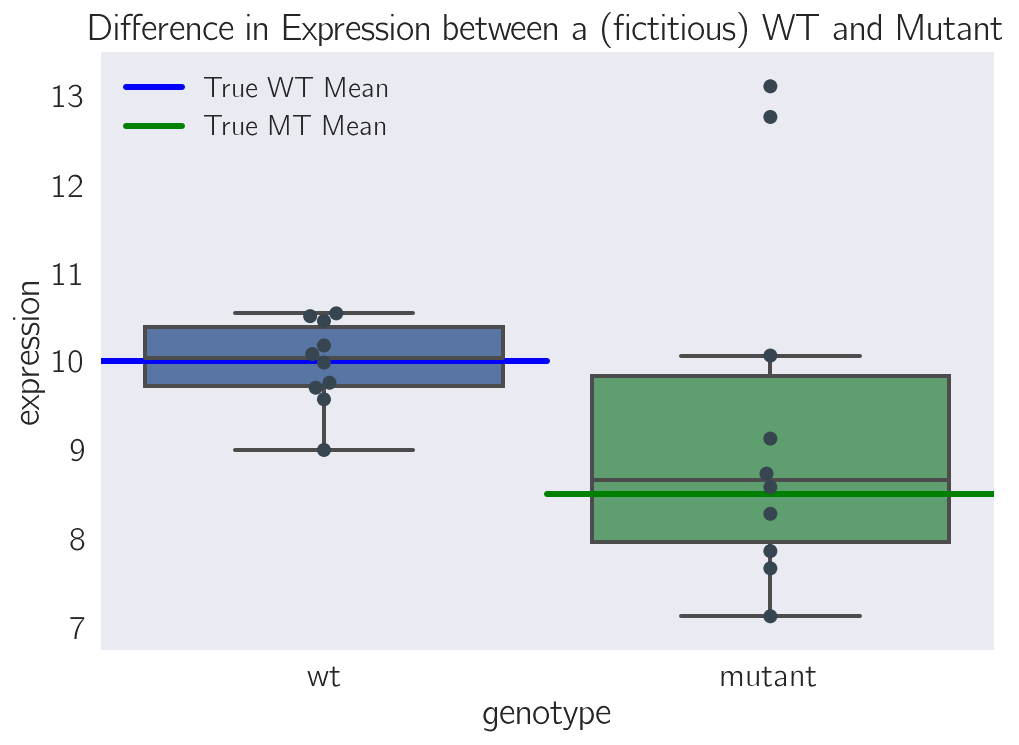

In [3]:
sns.boxplot(x='genotype', y='expression', data=tidy)
sns.swarmplot(x='genotype', y='expression', data=tidy, size=7, color='#36454F')
plt.gca().axhline(10, xmin=0, xmax=0.5, color='blue', label='True WT Mean', lw=3)
plt.gca().axhline(8.5, xmin=0.5, xmax=1, color='green', label='True MT Mean', lw=3)
plt.legend()
plt.title('Difference in Expression between a (fictitious) WT and Mutant')

From these results, we can already draw a number of tentative observations. Namely, the mutant data has a different spread from the wild-type data. 

Suppose that we would now like to quantify our certainty in the means of each sample. One way to do this is to calculate the mean of each sample, and then to also calculate a [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval) (CI). Usually, we might do this by finding the mean and calculating the *standard error of the mean* ($\sigma/\sqrt{n}$), but we should not do this for our data because they are not normally distributed! We can calculate the CIs another way. Let's introduce the non-parametric bootstrap.

# Estimating confidence intervals using the non-parametric bootstrap

The procedure to perform a non-parametric bootstrap is shown below.

Given some data vector `x` with length `n`:

1. Randomly select `n` points from `x` *with replacement*. This means the same point may appear up to `n` times in our new vector.
2. Compute a statistic of interest.
3. Store the statistic in an array.
4. Repeat many times. 

We place this procedure in the function `non_parametric_bootstrap`.

In [4]:
def non_parametric_bootstrap(x, f, nsim=1000, **kwargs):
    """
    
    Params:
    x, y - data (numpy arrays)
    f - test function to calculate
    nsim - number of simulations to run
    """
    statistic = np.zeros(nsim)
    for i in range(nsim):
        # simulate x
        indices = np.random.randint(0, len(x), len(x))
        X = x[indices]
        X += np.random.normal(0, 0.05, len(x))
        
        statistic[i] = f(X, **kwargs)
    
    return statistic

Using our `non_parametric_bootstrap` function, we can now go ahead and ask what the mean would be if we repeated this experiment many many times. How much would our guess of the mean vary each time?

In [5]:
wt = tidy[tidy.genotype == 'wt'].expression.values
mt = tidy[tidy.genotype == 'mutant'].expression.values

meanx = non_parametric_bootstrap(wt, np.mean)
meany = non_parametric_bootstrap(mt, np.mean)

Let's plot it:

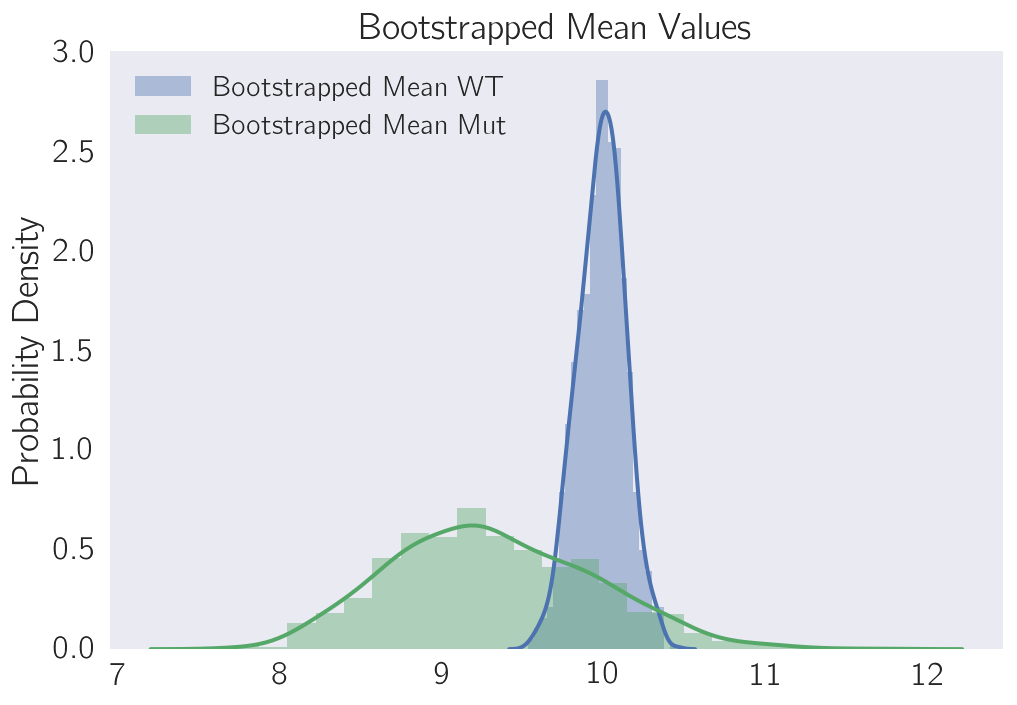

In [6]:
sns.distplot(meanx, label='Bootstrapped Mean WT')
sns.distplot(meany, label='Bootstrapped Mean Mut')
# plt.gca().axvline(logp.mean(), ls='--', color='k', label='mean pval')
# plt.gca().axvline(-np.log(0.05)/np.log(10), ls='--', color='r', label='statistical significance')
# plt.xlabel('$-\log_{10}{p}$')
plt.ylabel('Probability Density')
plt.title('Bootstrapped Mean Values')
plt.legend()

We can see that the wild-type sample mean is tightly centered around 10, whereas the mutant has a large spread centered at 9.5. Clearly, we are much more confident in the mean of the wild-type than in the mean of the mutant. We can quantify this by using the bootstrap to formally calculate our confidence intervals. 

Using the bootstrapped means, we will use the following procedure to calculate CIs from it:
1. Sort the bootstrapped means vector from low to high
2. Find the mean using the `numpy.mean()` function.
3. Find the entry that is at the entry that is 5% from the beginning of our array. We took 1,000 samples. 5% of 1000 is 50, so find the 50th entry in the array.
4. Do the same for the 95% entry (extract entry 950 in this example).
5. Print the mean and the CI.

If the CIs between both samples overlap, we should be careful -- that means we don't have optimal power to resolve the means of the two distributions.

In [7]:
def print_mean_and_confidence_intervals(btstrp):
    btstrp = np.sort(btstrp)
    mean = btstrp.mean()
    message = "Mean = {0:.2g}; CI = [{1:.2g}, {2:.2g}]"
    five = int(np.floor(0.05*len(btstrp)))
    ninetyfive = int(np.floor(0.95*len(btstrp)))
    print(message.format(mean, btstrp[five], btstrp[ninetyfive]))

print('Wild-type:')
print_mean_and_confidence_intervals(meanx)
print('Mutant:')
print_mean_and_confidence_intervals(meany)

Wild-type:
Mean = 10; CI = [9.7, 10]
Mutant:
Mean = 9.3; CI = [8.4, 10]


# The Mann-Whitney U test for equality of distributions

At this point, most biologists would like to know whether the means of the two distributions are the same or not. A commonly used test for non-normally distributed data is the **Mann-Whitney U test**. This statistic tests the null hypothesis that the distribution of the data in the wild-type sample and the mutant are exactly the same. The alternative hypothesis is that they are not the same. Does this mean that the means, or the medians, are not the same? No. We must be very careful about what conclusions we can draw from applying this test. 

We will use `scipy.stats.mannwhitney` to test this.

In [8]:
# scipy.stats.mannwhitneyu returns two things: a statistic value
# and a p-value. Choose the p-value by selecting the 2nd entry:
pvalue = scipy.stats.mannwhitneyu(wt, mt)[1]

if pvalue < 0.05:
    print('We reject the null hypothesis with a p-value of {0:.2g}'.format(pvalue))
else:
    print('We fail to reject the null hypothesis with a p-value of {0:.2g}'.format(pvalue))

We reject the null hypothesis with a p-value of 0.038


We can reject the null hypothesis that the two distributions are the same. What does this mean? That is a very complex statement. Maybe we would prefer simpler statements about the mean, the median or the variance of the distributions. How can we get at these simpler questions?

# Statistical testing using the non-parametric bootstrap

The answer lies once again in the bootstrap. To test a statement using a bootstrap, we must always follow the same recipe.

1. State the null hypothesis, and a statistic with which to test the statement.
2. Measure the observed statistic.
3. Model the null hypothesis using the data and compute the statistic for the simulated null datasets. Store the statistic from each run in an array.
4. Figure out the fraction of the time that the simulated dataset gave a statistic equal to or greater than the measured statistics. This is the p-value.

For our specific case:
1. The null hypothesis is 
$$
H_0: \mu_{wt} = \mu_{mt},
$$
and the statistic with which to test the statement is
$$
\delta = \mu_{wt} - \mu_{mt}
$$
2. Measure the observed statistic. Call it $\delta_{Obs}$.
3. Simulate what the null hypothesis would look like: Take the wild-type samples and the mutant samples, mix them together and make two new samples by picking from the mix with replacement. At random, call one sample the mutant and the other the wild-type. Each time, measure the statistic of interest.
4. Compute the p-value.

We do this using the functions below.

In [9]:
def difference_of_means(x, y):
    """Calculate the difference in the means of two datasets x and y. Returns a scalar equal to mean(y) - mean(x)"""
    return np.mean(y) - np.mean(x)

def test_null(x, y, statistic, iters=1000):
    """
    Given two datasets, test a null hypothesis using a permutation test for a given statistic.
    
    Params:
    x, y -- ndarrays, the data
    statistic -- a function of x and y
    iters -- number of times to bootstrap
    
    Ouput:
    a numpy array containing the bootstrapped statistic
    """
    def permute(x, y):
        """Given two datasets, return randomly shuffled versions of them"""
        # concatenate the data
        new = np.concatenate([x, y])
        # shuffle the data
        np.random.shuffle(new)
        # return the permuted data sets:
        return new[:len(x)], new[len(x):]

    # do the bootstrap
    return np.array([statistic(*permute(x, y)) for _ in range(iters)])

Run the computation!

In [10]:
diff = test_null(wt, mt, difference_of_means, iters=10**5)

Let's plot it:

The p-value for these samples is 0.18
We cannot reject the null hypothesis that the means are equal between both samples


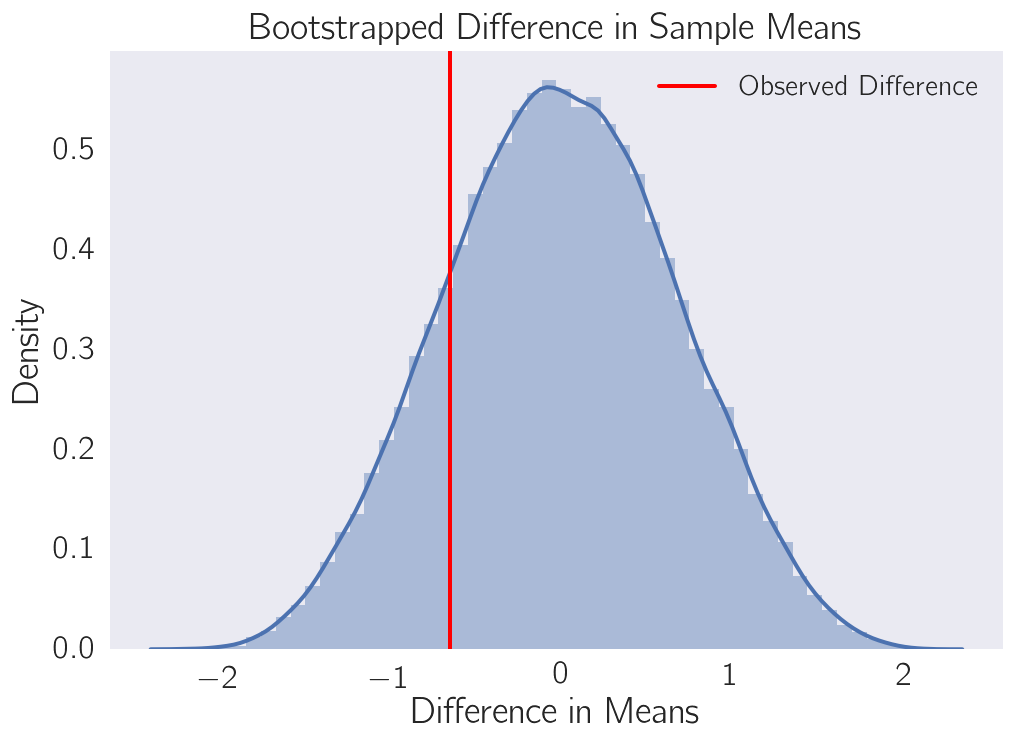

In [11]:
sns.distplot(diff)
plt.axvline(mt.mean() - wt.mean(), color='red',label='Observed Difference')
plt.title('Bootstrapped Difference in Sample Means')
plt.xlabel('Difference in Means')
plt.ylabel('Density')
plt.legend()

pvalue = len(diff[diff < mt.mean() - wt.mean()])/len(diff)

print('The p-value for these samples is {0:.2g}'.format(pvalue))
if pvalue < 0.05:
    print('We can reject the null hypothesis that the means are equal between both samples')
else:
    print('We cannot reject the null hypothesis that the means are equal between both samples')

Using non-parametric bootstraps, we can even ask whether the variances are statistically significantly different between the two groups:

In [12]:
def difference_of_variance(x, y):
    """Calculates the difference in variance between x and y."""
    
    return np.std(y)**2 - np.std(x)**2


diff_vars = test_null(wt - wt.mean(), mt - mt.mean(), difference_of_variance, iters=10**5)

The p-value for these samples is 0.001
We can reject the null hypothesis that the means are equal between both samples


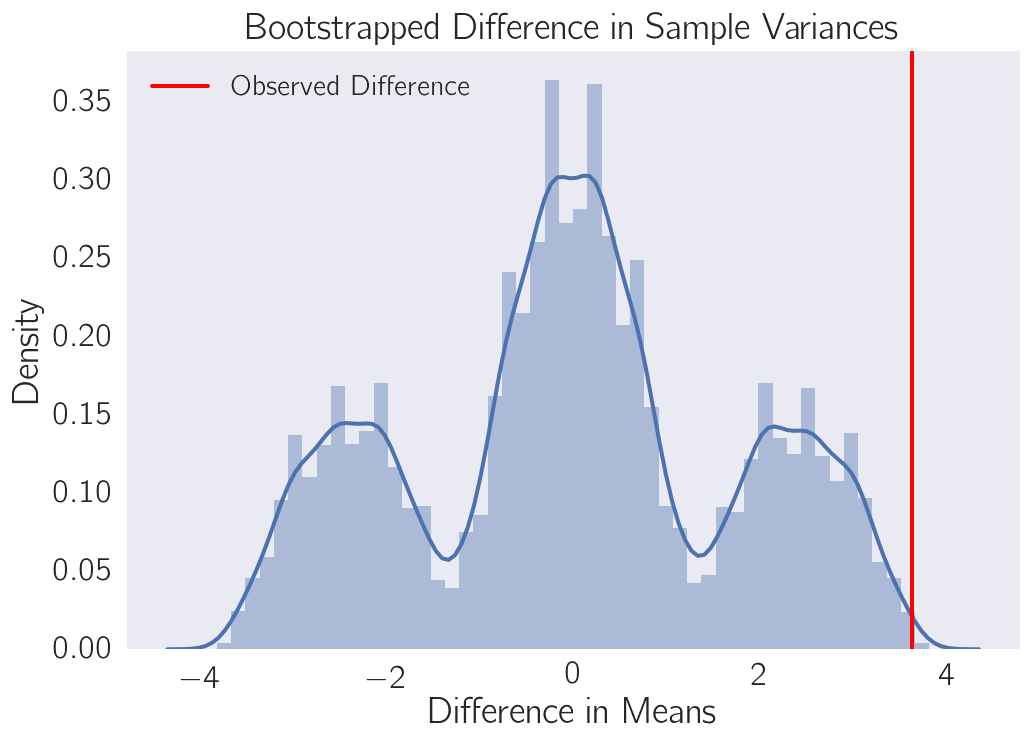

In [13]:
sns.distplot(diff_vars)
plt.axvline(mt.std()**2 - wt.std()**2, color='red',label='Observed Difference')
plt.title('Bootstrapped Difference in Sample Variances')
plt.xlabel('Difference in Means')
plt.ylabel('Density')
plt.legend()

pvalue = len(diff_vars[diff_vars > mt.std()**2 - wt.std()**2])/len(diff)

print('The p-value for these samples is {0:.2g}'.format(pvalue))
if pvalue < 0.05:
    print('We can reject the null hypothesis that the means are equal between both samples')
else:
    print('We cannot reject the null hypothesis that the means are equal between both samples')

# Repeating the analysis for a different sample is straightforward

Let's try the bootstraps again, on a slightly different dataset. The entire analysis will take only a few lines.

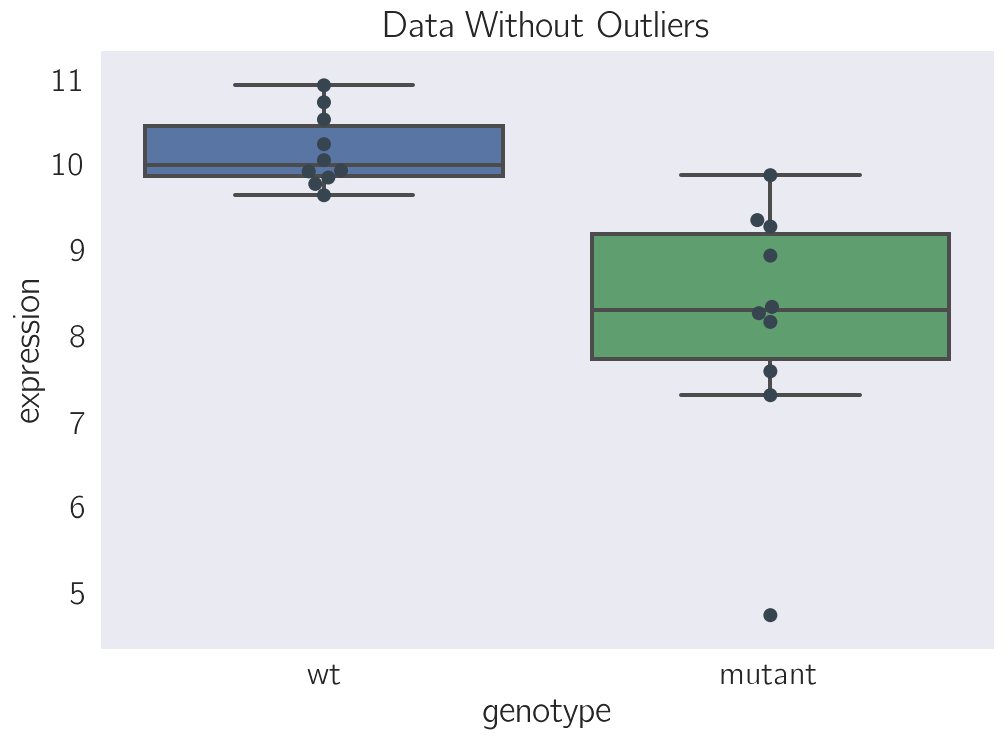

In [14]:
x = np.random.normal(10, .5, 10)
y = np.random.standard_t(2.7, 10) + 8.5 # subtract 0.5 to make mean(y) = -0.5

data = np.vstack([x, y]).transpose()
df = pd.DataFrame(data, columns=['wt', 'mutant'])

# tidy:
tidy = pd.melt(df, var_name = 'genotype', value_name='expression')
sns.boxplot(x='genotype', y='expression', data=tidy)
sns.swarmplot(x='genotype', y='expression', data=tidy, size=7, color='#36454F')

plt.title('Data Without Outliers')

Ask whether the null hypothesis that the means are the same can be rejected:

In [15]:
# calculate the differences
wt = tidy[tidy.genotype == 'wt'].expression.values
mt = tidy[tidy.genotype == 'mutant'].expression.values
diff = test_null(wt, mt, difference_of_means, iters=10**5)
pvalue = len(diff[diff > mt.std()**2 - wt.std()**2])/len(diff)

print('Wild-type Mean')
print_mean_and_confidence_intervals(non_parametric_bootstrap(wt, np.mean))
print('Mutant-type Mean')
print_mean_and_confidence_intervals(non_parametric_bootstrap(mt, np.mean))

if pvalue < 0.05:
    print('We can reject the hypothesis that the means are equal between both samples with a p = {0:.2g}'.format(pvalue))
else:
    print('We cannot reject the hypothesis that the means are equal between both samples (p = {0:.2g})'.format(pvalue))

Wild-type Mean
Mean = 10; CI = [10, 10]
Mutant-type Mean
Mean = 8.2; CI = [7.4, 8.9]
We can reject the hypothesis that the means are equal between both samples with a p = 0.00071


Ask whether we can reject the null hypothesis that the variances are the same between the two samples:

In [16]:
# do the same for the variance:
diff_vars = test_null(wt - wt.mean(), mt - mt.mean(), difference_of_variance, iters=10**5)
pvalue = len(diff_vars[diff_vars > mt.std()**2 - wt.std()**2])/len(diff_vars)

print('Wild-type Variance:')
print_mean_and_confidence_intervals(non_parametric_bootstrap(wt, np.var))
print('Mutant-type Variance:')
print_mean_and_confidence_intervals(non_parametric_bootstrap(mt, np.var))

if pvalue < 0.05:
    print('We can reject the hypothesis that the variances are equal between both samples with a p = {0:.2g}'.format(pvalue))
else:
    print('We cannot reject the hypothesis that the variances are equal between both samples (p = {0:.2g})'.format(pvalue))

Wild-type Variance:
Mean = 0.15; CI = [0.054, 0.23]
Mutant-type Variance:
Mean = 1.6; CI = [0.39, 3.4]
We can reject the hypothesis that the variances are equal between both samples with a p = 0.0076
